In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


True
NVIDIA GeForce RTX 3050 Laptop GPU


In [2]:
# -------------------------------
# 1️⃣ Import Libraries
# -------------------------------
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchcam.methods import SmoothGradCAMpp
from torchvision.transforms import ToPILImage


In [3]:
# -------------------------------
# 2️⃣ Device Setup
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [4]:
# -------------------------------
# 3️⃣ Dataset & Transform
# -------------------------------
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root="./Dataset/", transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print("Classes:", dataset.classes)
print("Train size:", len(train_dataset))
print("Test size:", len(test_dataset))


Classes: ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']
Train size: 2843
Test size: 711


In [5]:
# -------------------------------
# 4️⃣ CNN Model (Auto Linear Size)
# -------------------------------
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.25)

        # Dynamically compute linear size
        self.flatten_dim = self.get_flatten_dim()

        self.fc1 = nn.Linear(self.flatten_dim, 256)
        self.fc2 = nn.Linear(256, len(dataset.classes))

    def get_flatten_dim(self):
        x = torch.zeros(1, 3, 512, 512)
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        return x.numel()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CNN().to(device)


In [6]:
# -------------------------------
# 5️⃣ Loss & Optimizer
# -------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [7]:
# -------------------------------
# 6️⃣ Training Function
# -------------------------------
def train_model(model, dataloader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss/len(dataloader):.4f}")

train_model(model, train_loader, criterion, optimizer, epochs=10)


Epoch 1/10 - Loss: 0.3578
Epoch 2/10 - Loss: 0.0974
Epoch 3/10 - Loss: 0.0736
Epoch 4/10 - Loss: 0.0725
Epoch 5/10 - Loss: 0.0501
Epoch 6/10 - Loss: 0.0466
Epoch 7/10 - Loss: 0.0853
Epoch 8/10 - Loss: 0.0563
Epoch 9/10 - Loss: 0.0451
Epoch 10/10 - Loss: 0.0414


In [9]:
# -------------------------------
# 7️⃣ Testing Function
# -------------------------------
def test_model(model, dataloader, criterion):
    model.eval()
    total = 0
    correct = 0
    total_loss = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    print(f"Test Loss: {total_loss/len(dataloader):.4f}")
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

test_model(model, test_loader, criterion)


Test Loss: 0.1716
Test Accuracy: 98.31%


In [17]:
print(model)


CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=262144, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=5, bias=True)
)


In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

def visualize_grad_cam_with_circles(model, dataset, index=0, threshold=0.6):
    model.eval()
    img, label = dataset[index]
    input_tensor = img.unsqueeze(0).to(device)

    output = model(input_tensor)
    pred_class = output.argmax(dim=1).item()

    # ✅ Generate Grad-CAM heatmap
    activation_map = cam_extractor(pred_class, output)[0].cpu().detach().numpy()

    # Normalize safely
    activation_map = activation_map.squeeze()
    if activation_map.max() != activation_map.min():
        activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())
    else:
        activation_map[:] = 0

    # ✅ Convert tensor to image
    to_pil = ToPILImage()
    original_img = np.array(to_pil(img))

    # Resize activation map to match image
    heatmap_resized = cv2.resize(activation_map, (original_img.shape[1], original_img.shape[0]))

    # ✅ Threshold the heatmap to find hotspots
    thresh_map = (heatmap_resized > threshold).astype(np.uint8)

    # Find contours around the most activated regions
    contours, _ = cv2.findContours(thresh_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # ✅ Overlay Grad-CAM + draw circles
    overlay = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(overlay, 0.5, original_img, 0.5, 0)

    # Draw circles or contours around hot areas
    for contour in contours:
        (x, y), radius = cv2.minEnclosingCircle(contour)
        if radius > 5:  # filter out small noise
            center = (int(x), int(y))
            cv2.circle(overlay, center, int(radius), (0, 255, 0), 2)  # green circle

    # ✅ Show the final image
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted: {dataset.dataset.classes[pred_class]}")
    plt.axis("off")
    plt.show()


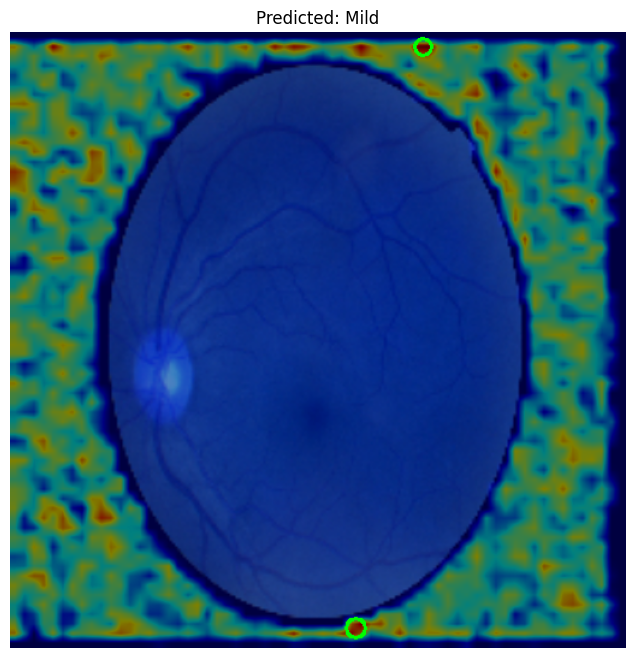

In [100]:
visualize_grad_cam_with_circles(model, test_dataset, index=4, threshold=0.8)


In [112]:
import torch

# Assume 'model' is your trained CNN
# And 'dataset_classes' is a list of class names, e.g., dataset.classes
dataset_classes = ['Mild','Moderate','No_DR','Proliferate_DR','Severe']  # replace with your dataset classes

# Save model weights
torch.save(model.state_dict(), "model.pth")
print("Model weights saved as model.pth")

# Save class names
torch.save(dataset_classes, "classes.pth")
print("Class names saved as classes.pth")


Model weights saved as model.pth
Class names saved as classes.pth
